# MNIST Classification using subspace method.

In [1]:
import torch
from torchvision import transforms as T
from torchvision.datasets import MNIST

# Loads the mnist Dataset. This dataset outputs
# flattened images of each number.
mnist_train = MNIST("~/datasets", download=True, train=True,
                    transform=T.Compose([T.ToTensor(), torch.flatten]))

In [2]:
import sys
sys.path.append("..")

from subspyces.core import VectorSpace
from subspyces.generators import IdentityGenerator

# We use an IdentityGenerator to re-organize the mnist dataset
# as a list of VectorSpace, loading the full dataset to memory
generator = IdentityGenerator()
train_vector_spaces = generator.generate(mnist_train, batch_size=512)

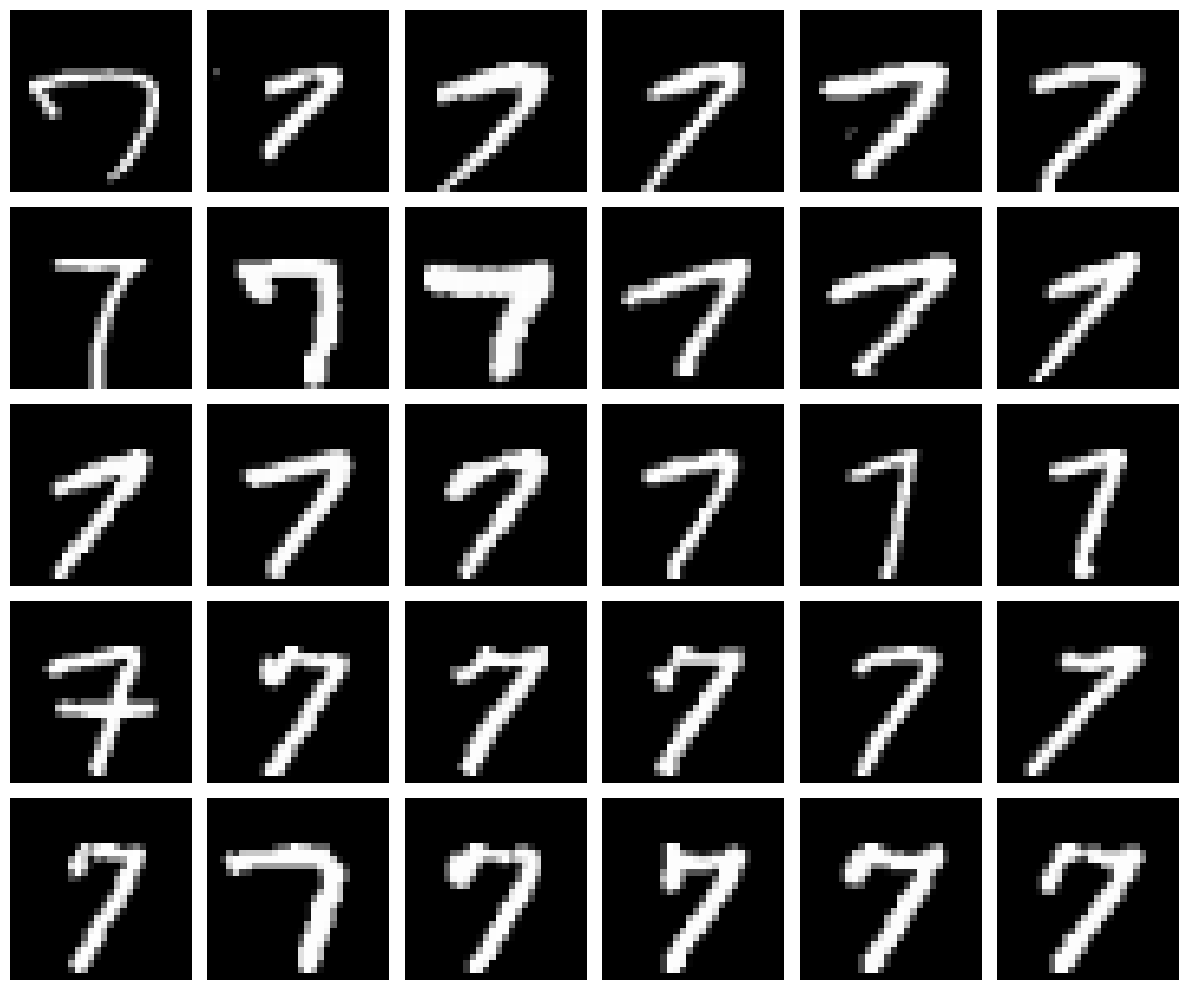

In [3]:
# We can vizualize the images using the vizualize_images
# funtion from subspyce.utils. For example, vizualizing
# some samples of the number 7

from subspyces.utils import vizualize_images

label = 7
vizualize_images(train_vector_spaces[label],
                 slice(0, 30),
                 image_shape=[28, 28])

In [4]:
# Now, let's apply PCA on each VectorSpace and transform
# our data into a subspace representation. For this, we
# can use the subspyce.transform module.
from subspyces.transform import PCATransform

pca_transform = PCATransform(n_components=30)

pca_vector_subspaces = dict()

for vector_space in train_vector_spaces.values():
    pca_vector_subspace = pca_transform.transform(vector_space)
    pca_vector_subspaces[pca_vector_subspace.label] = pca_vector_subspace

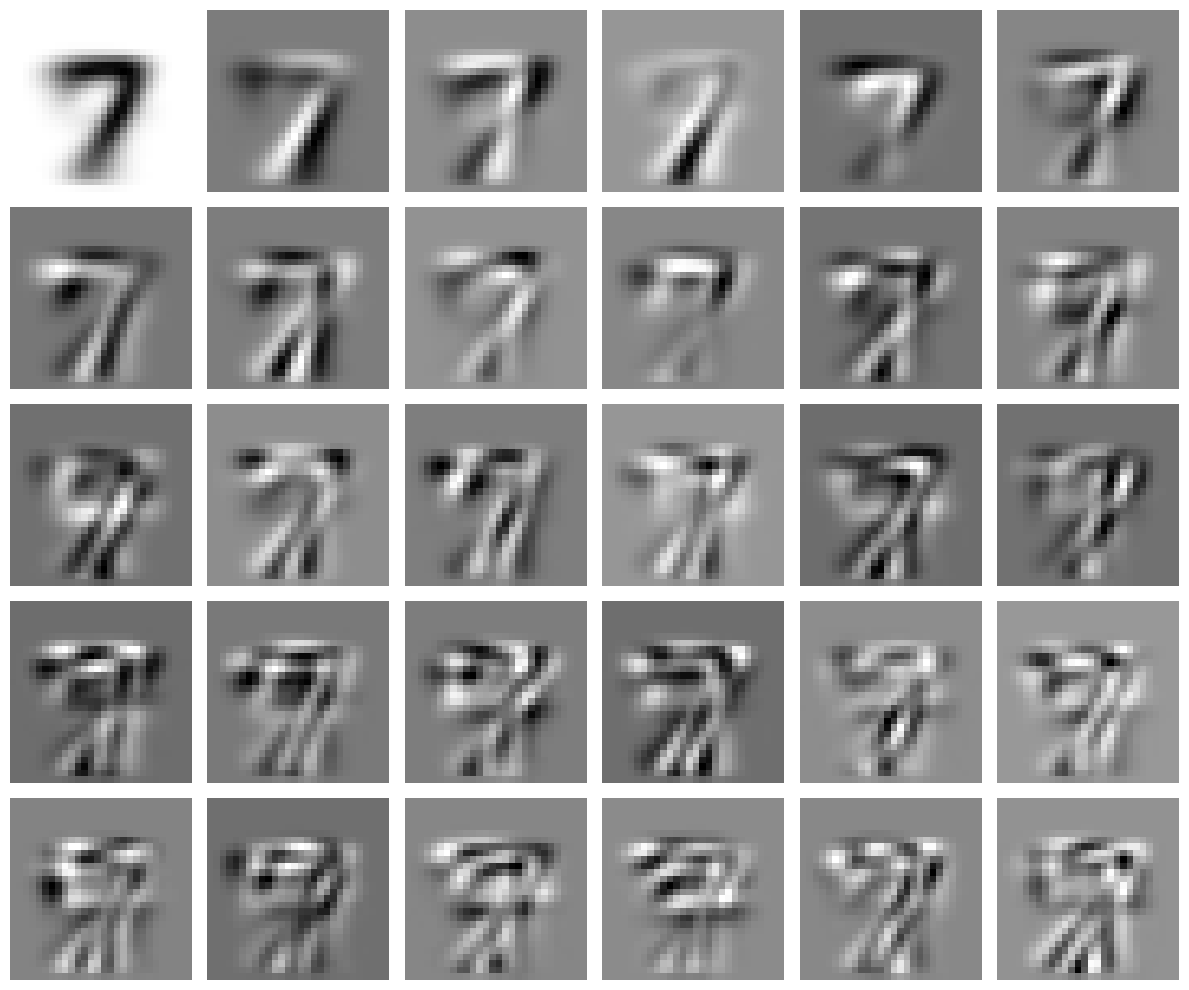

In [5]:
# Now, we can vizualize the PCA subspace representation
# of our data using the same vizualize_images function.

label = 7
vizualize_images(pca_vector_subspaces[label],
                 slice(0, 30),
                 image_shape=[28, 28])

In [6]:
# Let's classify our data into these pca subspaces using our testing data
# First, we need a torch Dataset with our test data
mnist_test = MNIST("~/datasets", download=True, train=False,
                   transform=T.Compose([T.ToTensor(), torch.flatten]))

# Now, we can classify this into our subspaces. Let's define a classification
# function that receives a vector and classifies it into one of the subspaces.
from subspyces.metrics import cosine_similarity
def classify(input_vector, trained_subspaces):
    """
    Classifies a tensor in one of the subspaces using the mean squared of canonical angles
    """
    # Classify all vectors by cossine similarity
    max_likelihood = torch.empty((0, len(input_vector)))

    for subspace in trained_subspaces.values():
        # Calculate the mean square cosine similarity
        cs = cosine_similarity(input_vector, subspace)
        mean_square_cs = torch.mean(torch.square(cs), dim=1).unsqueeze(0)
        max_likelihood = torch.cat([max_likelihood, mean_square_cs], 0)
    # See which subspace index the vector is closer to
    max_likelihood = torch.argmax(max_likelihood, dim=0)
    # Transform subspace index to labels
    max_likelihood = [list(trained_subspaces)[i] for i in max_likelihood]
    return max_likelihood

In [7]:
# Now, let's go through our torch Dataset and classify our testing data!
from torch.utils.data import DataLoader
loader = DataLoader(mnist_test, batch_size=32)

classification_ratio = 0

for n_batch, (batch_data, batch_label) in enumerate(loader):
    correct_class = []
    predicted_labels = classify(batch_data, pca_vector_subspaces)

    for l1, l2 in zip(predicted_labels, batch_label):
        correct_class.append(l1 == l2)

    classification_ratio += correct_class.count(True) / len(batch_data)
classification_ratio /= (n_batch+1)

# Let's see our classification ratio!
print(classification_ratio)

0.9574680511182109


In [8]:
# Now, this simple method is already implemented in subspyce.
# Just import the methods.SubspaceMethod
from subspyces.methods import SubspaceMethod

subspace_method = SubspaceMethod()
subspace_method.train(mnist_train, n_components=30, batch_size=512)
classification_ratio = subspace_method.eval(mnist_test)
print(classification_ratio)

0.9574680511182109


In [9]:
# Now you can go ahead and try another Dataset!
from torchvision.datasets import CIFAR10

cifar10_train = CIFAR10("~/datasets", download=True, train=True,
                        transform=T.Compose([T.ToTensor(), torch.flatten]))
cifar10_test = CIFAR10("~/datasets", download=True, train=False,
                       transform=T.Compose([T.ToTensor(), torch.flatten]))

subspace_method = SubspaceMethod()
subspace_method.train(cifar10_train, n_components=30, batch_size=512)

Files already downloaded and verified
Files already downloaded and verified


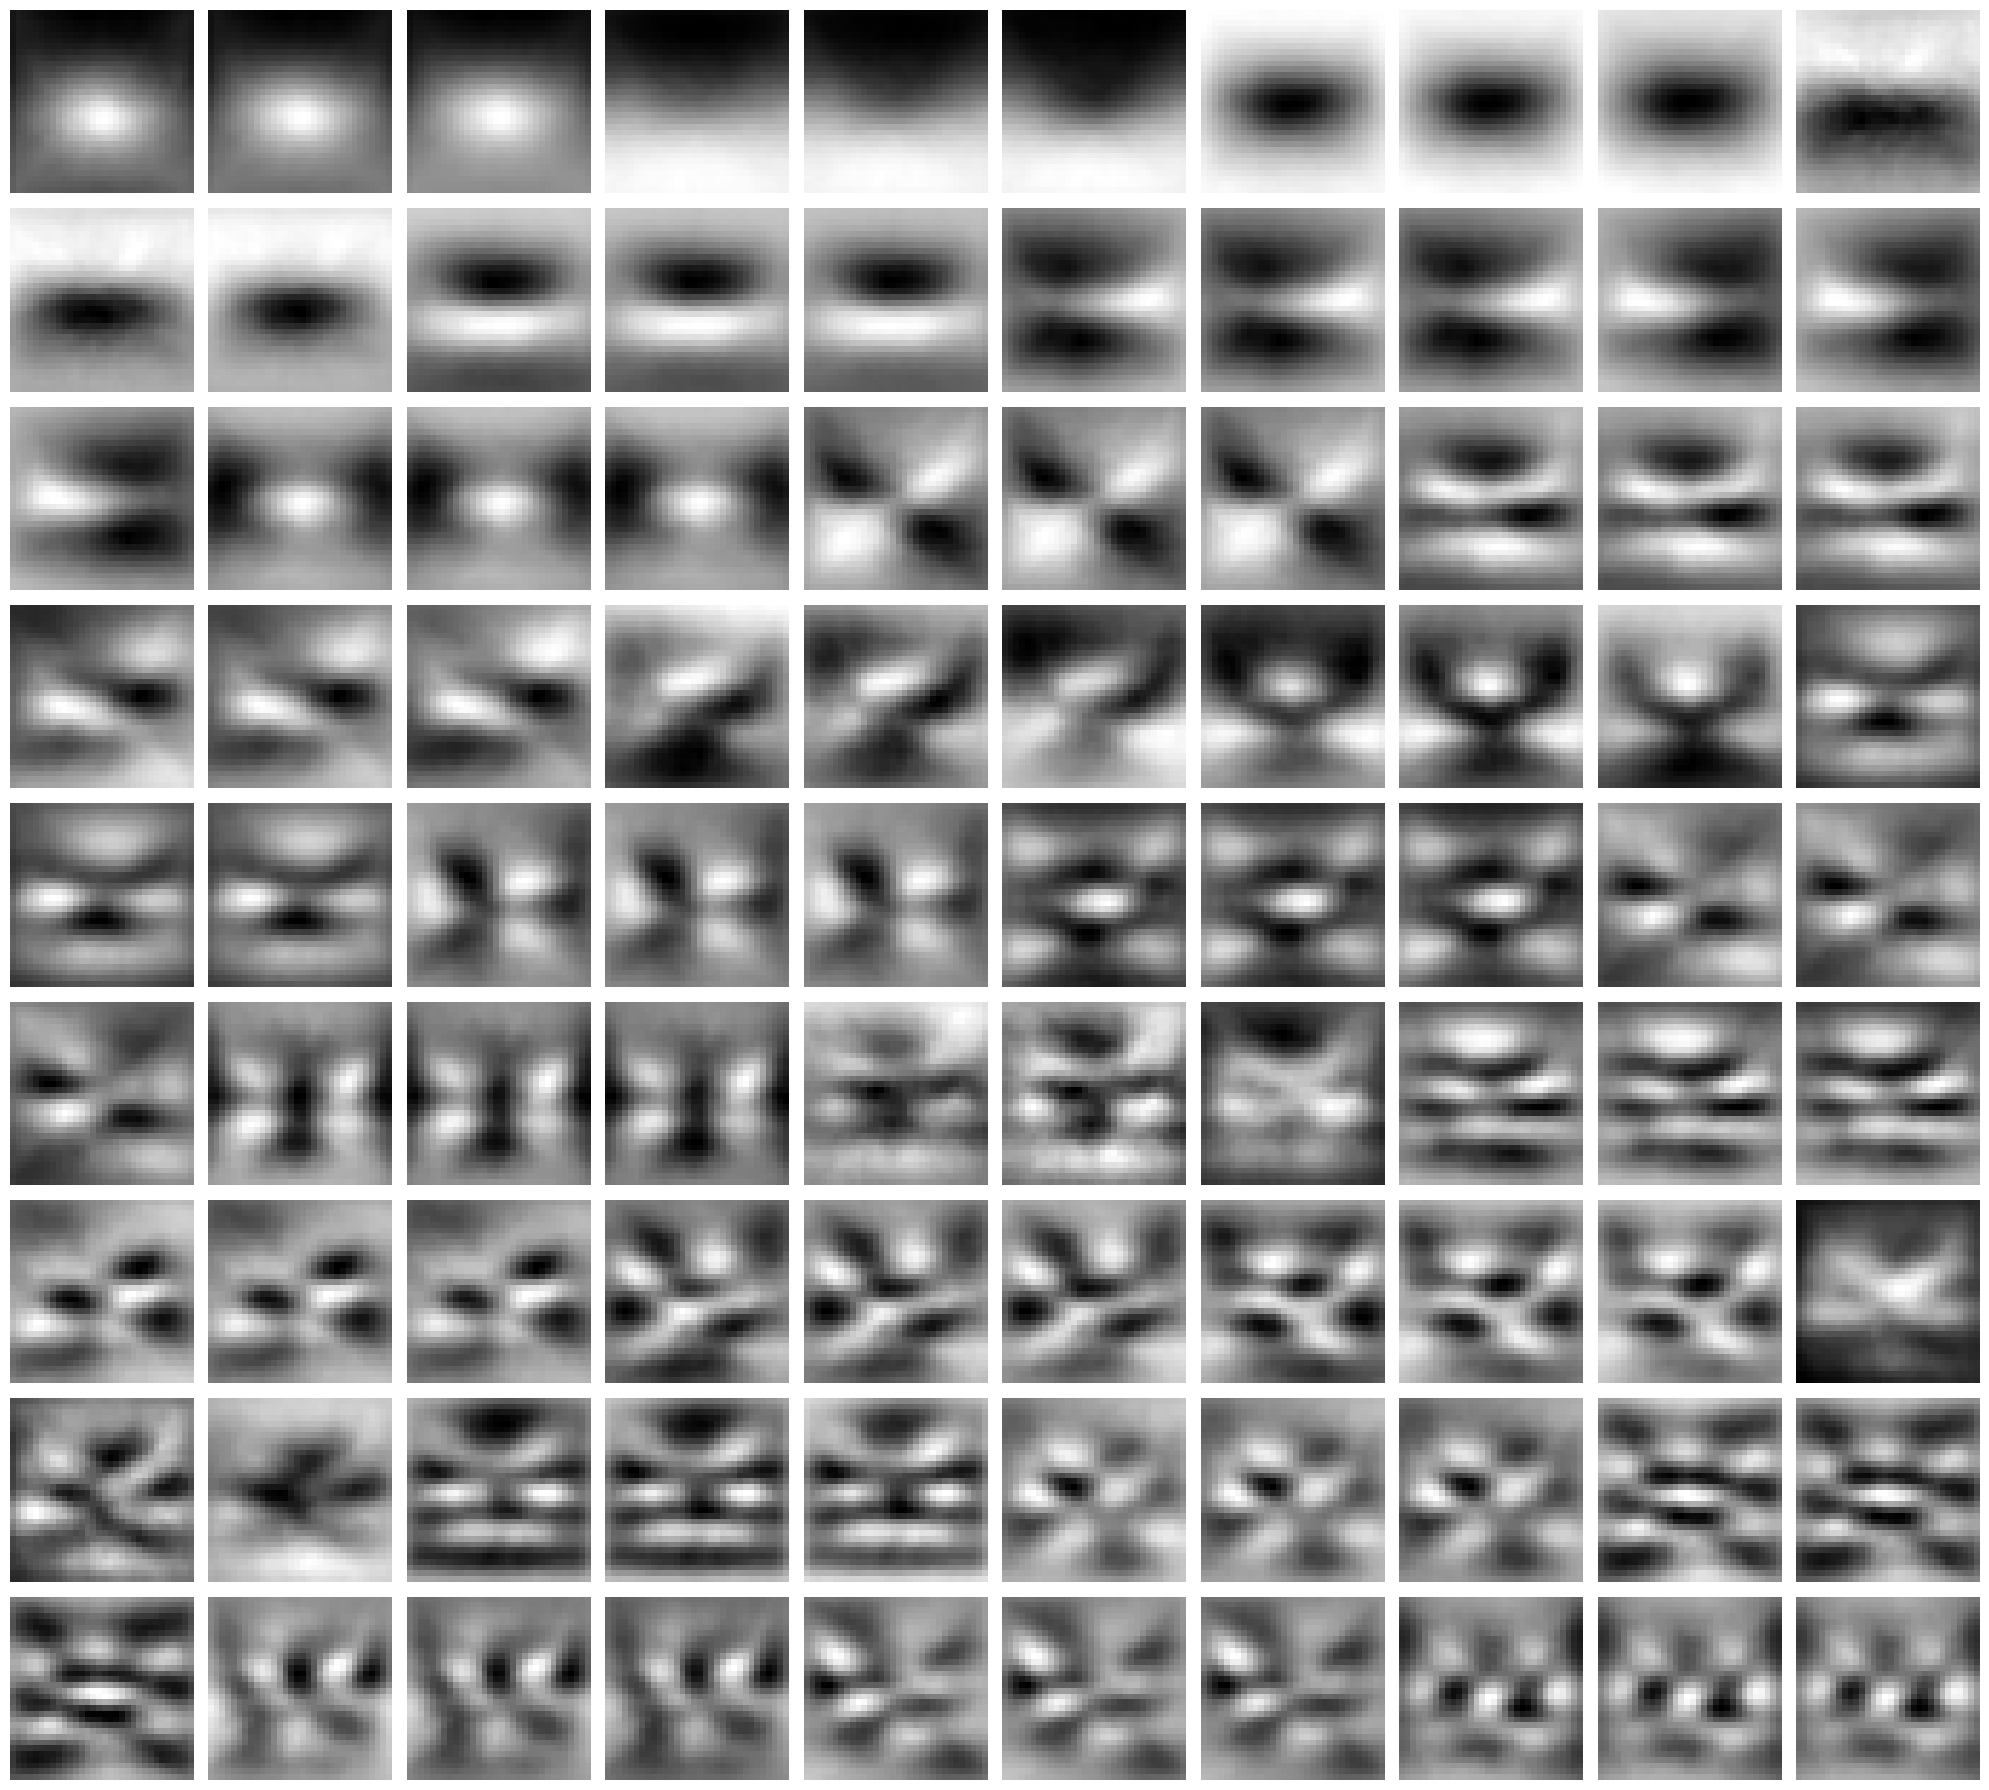

In [10]:
label = 0
vizualize_images(subspace_method._model_parameters[label],
                 slice(0, 30),
                 image_shape=[32, 32])

In [11]:
classification_ratio = subspace_method.eval(cifar10_test)

print(classification_ratio)
# Classification is not that good on CIFAR >.<
# We need to improve it!

0.38428514376996803
